# ANOVA and Linear Regression

This notebook is meant to aid in visualizing how ANOVA and Linear Regression are actually doing the same thing. 
First we need to import a few libraries and setup some data. Our fake data here is meant to show how fast in hours a drug relieves symptoms. We want to see if there is a difference between a control (placebo), regular, and extra strength version of the medications.

Before looking at this notebook, this StackOverflow question is a good place to get a nice idea of what ANOVA is doing http://stats.stackexchange.com/questions/5278/how-to-visualize-what-anova-does/5280#5280 as well as this blog post http://rpsychologist.com/d3-one-way-anova.

In [78]:
from pandas import DataFrame
import pandas as pd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
%matplotlib inline


data = {
    "Control": [
        22,
        13.5,
        21.5,
        20.5,
        19,
        23
    ],
    "regular": [
        33,
        32.5,
        24,
        29,
        27,
        27
    ],
    "extra": [
        22,
        25,
        24,
        27.5,
        25,
        28
    ]
}

This data is in an unstacked format, but for inputting this into the ANOVA and regression libraries, it is easier if we have two columns, one column with the time-to-relief, and another column with the corresponding treatment. This is the "stacked" format.

In [79]:
data_stacked = {
    "hour":[],
    "treatment":[]
}

for key, values in data.items():
    data_stacked["treatment"].extend([key]*len(values))
    data_stacked["hour"].extend(values)
df = DataFrame(data_stacked)

Next we use statsmodels to run an ANOVA on our data and view the results.

In [80]:
model = ols('hour ~ C(treatment)', data=df)
anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(treatment),2,237.444444,118.722222,12.327661,0.000681
Residual,15,144.458333,9.630556,NaN,NaN


We can see here that our ANOVA has a relatively large F-Value indicating that one or more of the group means differ from one another. We can visualize this by take a look at the three different groups side-by-side. Visualization inspired from https://github.com/thomas-haslwanter/statsintro_python/blob/master/ipynb/8_anovaOneway.ipynb, which is also a great resource for statistics in Python.

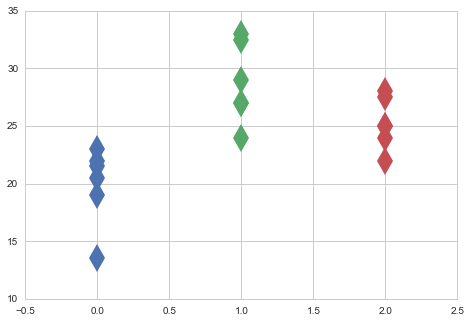

In [81]:
df2 = DataFrame(data)
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
for index, g in enumerate(data.keys()):
    axes.plot([index]*len(df2[g]), df2[g], 'd', ms=20)
axes.set_xbound([-0.5,2.5])

Visually, it looks like the first group is centered around a different value than the other two groups. The results of the ANOVA back up this intuition. The numerator of the F-statistic is the variance between groups, and the denominator is the variance within groups. Intuitively, the larger F-statistic means that the variance between groups overshadows the variance within groups which indicates that the means of one or more of the groups likely differ. See here for more https://en.wikipedia.org/wiki/F-test#Multiple-comparison_ANOVA_problems

So what does this have to do with a linear regression? It turns out they are really the same thing (which the above Python code for running the ANOVA kind of gives away), but it requires that we re-code our variables using "dummy-coding" before running the regression. This means we create a new variable for each feature or group. The variable is equal to 1 when the depedendent variable (here, hours to relief) is from that group, and 0 when it is not. It turns out that you only N - 1 indicator variables to represent N groups, because when the N - 1 variables are set to 0 it means the dependent variable is from the left-out "reference" group. We will use the get_dummies function from the Pandas library below to create these new variables for us. After that, we will run a regression and confirm our resulting F-Value is the same as the ANOVA.

In [82]:
dummies = pd.get_dummies(df.treatment, prefix='trt').iloc[:,1:]
model = ols("hour ~ trt_regular + trt_extra", data = pd.concat([df, dummies], axis=1))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hour   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     12.33
Date:                Sat, 28 Nov 2015   Prob (F-statistic):           0.000681
Time:                        22:19:03   Log-Likelihood:                -44.284
No. Observations:                  18   AIC:                             94.57
Df Residuals:                      15   BIC:                             97.24
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      19.9167      1.267     15.721      0.000        17.216    22.617
trt_regular     8.8333      1.792      4.930      0.000         5.014    12.652
trt_extra       5.3333      1.792      2.977      0.009         1.514     9.152
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.925
Skew:                          -0.525   Prob(JB):                        0.630
Kurtosis:                       2.640   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As promised, the F-Value is the same, 12.33. Now in the context of a regression, the F-value compares our current model to the "reduced" model which only contains the intercept (http://blog.minitab.com/blog/adventures-in-statistics/what-is-the-f-test-of-overall-significance-in-regression-analysis
). We can think of this as answering the question: "Does the increased complexity of our current model deliver significantly better results than a much simpler model?" A larger F-value indicates that it does. But what does this have to do with the F-Value from the linear regression. Let's start by taking away the "extra strength" level of our factor and just looking a a graph of our "dummy variables" for "control" and "regular strength".

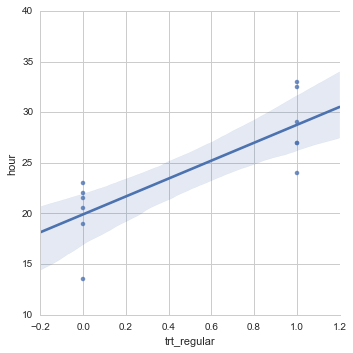

In [83]:
# Visualizing ANOVA 
df2 = pd.concat([df, dummies], axis=1)
fig = sns.lmplot(x='trt_regular', y='hour', data=df2.iloc[0:12,:])

Here we only have one indicator variable (because we are looking at only two levels of our factor). The points above 0 (when the indicator variable for "regular strength" is 0) correspond to the control groups, and the points above 1 correspond to the "regular strength" group. We have also shown the corresponding resulting regression line. As discussed above, our F-test is going to tell us whether this model, with effectively 1 variable, is significantly better than a straight horizontal line (intercept only). Intuitively it looks like the answer here would be yes. Below we run the regression and look at the results as well as the same two-level regression as ANOVA.

In [84]:
model = ols("hour ~ trt_regular", data = df2.iloc[0:12,:])
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hour   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     19.57
Date:                Sat, 28 Nov 2015   Prob (F-statistic):            0.00129
Time:                        22:19:04   Log-Likelihood:                -30.822
No. Observations:                  12   AIC:                             65.64
Df Residuals:                      10   BIC:                             66.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      19.9167      1.412     14.108      0.000        16.771    23.062
trt_regular     8.8333      1.997      4.424      0.001         4.385    13.282
==============================================================================
Omnibus:                        1.078   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.583   Jarque-Bera (JB):                0.802
Skew:                          -0.558   Prob(JB):                        0.670
Kurtosis:                       2.403   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
model = ols('hour~ C(treatment)', data=df2.iloc[0:12,:])
anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(treatment),1,234.083333,234.083333,19.574913,0.001285
Residual,10,119.583333,11.958333,NaN,NaN


Again, as promised, the F-Values are the same.  We can also take a look in the regression coefficients to see what they are telling us about the regression. The intercept is the mean of the control group

In [86]:
# http://www.theanalysisfactor.com/why-anova-and-linear-regression-are-the-same-analysis/
np.mean(data['Control']) # This is the intercept

19.916666666666668

and the coefficient for the dummy variable plus the coefficent (19.9167 + 8.8333) is the mean of the "regular" treatment group.

In [87]:
np.mean(data['regular']) # This is intercept + Coefficient

28.75

So let's add back in the third level. We run the regression below.

In [88]:
model = ols("hour ~ trt_regular + trt_extra", data = df2.iloc[0:18,:])
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hour   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     12.33
Date:                Sat, 28 Nov 2015   Prob (F-statistic):           0.000681
Time:                        22:19:04   Log-Likelihood:                -44.284
No. Observations:                  18   AIC:                             94.57
Df Residuals:                      15   BIC:                             97.24
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      19.9167      1.267     15.721      0.000        17.216    22.617
trt_regular     8.8333      1.792      4.930      0.000         5.014    12.652
trt_extra       5.3333      1.792      2.977      0.009         1.514     9.152
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                0.925
Skew:                          -0.525   Prob(JB):                        0.630
Kurtosis:                       2.640   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We then use the forumla for the corresponding regression equation (a plane in this case). If we graph the dummy-encoded groups (now in 3 dimensions) and show the plane, we can see that the F-test in this regression compares the two planes in the image, the one with the two dummy-encoded variables, and one contains only the intercept.

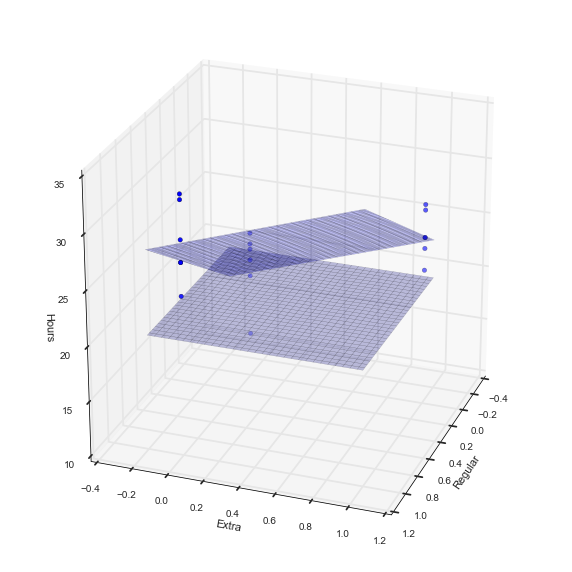

In [89]:
way = df2.iloc[0:18]
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(xs=way['trt_regular'], ys=way['trt_extra'], zs=way['hour'])
ax.set_ylabel('Extra')
ax.set_zlabel('Hours')
ax.set_xlabel('Regular')
ax.set_ybound(0, 1.1)
ax.set_xbound(0, 1.1)
ax.view_init(25, 20)
x_surf=np.arange(-0.2, 1, 0.01)
y_surf=np.arange(-0.2, 1, 0.01)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
z_surf = 19.9167 + 8.8333*x_surf + 5.3333 * y_surf
ax.plot_surface(x_surf, y_surf, z_surf, rstride=4, cstride=4, alpha=0.25)
ax.plot_surface(x_surf, y_surf, 19.9167,  rstride=4, cstride=4, alpha=0.25)

It is not obvious, but you can imagine that the plane using the two dummy-coded variables (on top) does a better job describing the 3 groups of dummy-coded variables in 3 dimensions than the plane that is described only by the intercept (below).

Other Links

http://www.unt.edu/rss/class/Jon/MiscDocs/Cohen_1968.pdf


https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb